In [ ]:
import numpy as np
import energyflow as ef
import torch
import jetnet
import cv2
import matplotlib.pyplot as plt

device = torch.device('cuda:0')
ONE_HUNDRED_GEV = 100.0
R = 0.4

In [ ]:
img_2d_coord_mat = torch.tensor(np.meshgrid(np.arange(28), np.arange(28))).T.reshape(-1,2)

def img_to_sig_cv2(arr):
    # create a signature to rep. img matrix for cv2 https://docs.opencv.org/2.4/modules/imgproc/doc/histograms.html#emd
    sig = torch.hstack((arr.flatten()[...,np.newaxis], img_2d_coord_mat))
    return sig.numpy()

def calc_emd_cv2(img1, img2):
    # calculate the emd between an image pair
    sig1 = img_to_sig_cv2(img1)
    sig2 = img_to_sig_cv2(img2)
    emd_val = cv2.EMD(sig1, sig2, cv2.DIST_L2)[0]
    return emd_val

def calc_emd_on_batch_cv2(img1, img2):
    # non-vectorized calculation between 2 batches
    emds = []
    for i1, i2 in zip(img1, img2):
        emd_val = calc_emd_cv2(i1, i2)
        emds.append(emd_val)
    return torch.tensor(emds)

In [ ]:
# slower than cv2. Results in values of different scale but same distribution
jet_coord_grid_step = R * 2 / 28
coord_axis = np.arange(-R, R, jet_coord_grid_step) + jet_coord_grid_step / 2
jet_img_coord = torch.tensor(np.meshgrid(coord_axis, coord_axis)).T.reshape(-1,2) # eta x phi for 28x28 grid

def img_to_part_array_ef(img):
    # make (pt, eta, phi) feat arr
    arr = torch.hstack((img.flatten().unsqueeze(1), jet_img_coord))
    return arr.numpy()

def calc_emd_ef(arr1, arr2):
    emd = ef.emd.emd(arr1, arr2, R=R)/ONE_HUNDRED_GEV
    return emd

def calc_emd_on_batch_ef(img1, img2):
    emds = []
    for i1, i2 in zip(img1, img2):
        a1, a2 = img_to_part_array_ef(i1), img_to_part_array_ef(i2)
        emd_val = calc_emd_ef(a1, a2)
        emds.append(emd_val)
    return torch.tensor(emds)

### Load in Dataset and Process to Images

In [ ]:
data = ef.qg_jets.load(num_data=4000, pad=True, ncol=4, generator='pythia', with_bc=False, cache_dir='~/.energyflow')[0]

In [ ]:
data = data[...,:-1] # drop pid from column features

# preprocess by centering jets and normalizing pts
for x in data:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

data_pre_img = data[:,:,[1,2,0]] # pt eta phi -> eta phi pt (order matters for to_image func)

In [ ]:
imgs = []
for jet in data_pre_img:
    img = jetnet.utils.to_image(jet, im_size=28, maxR=0.4)
    if img.sum() > 0:
        imgs.append(img)

In [ ]:
imgs = np.stack(imgs)
imgs = imgs[:, np.newaxis, ...] # add feature channel
imgs = torch.tensor(imgs, dtype=torch.float32)
imgs.shape

In [ ]:
# 80:20 train val split
rand_inds = torch.randperm(len(imgs))
thresh = int(0.8 * len(rand_inds))
train_imgs = imgs[rand_inds[:thresh]]
valid_imgs = imgs[rand_inds[thresh:]]

train_data = data[rand_inds[:thresh]] # pt eta phi matrices
valid_data = data[rand_inds[thresh:]]
print(train_imgs.shape, valid_imgs.shape, train_data.shape, valid_data.shape)

### Compare CV2 And Energyflow

In [ ]:
# 1. loop through batch of images
# 2. Generate emd scores with ef
# 3. Repeat with cv2
# 4. plot distributions

ef_emds = []

subset_imgs = valid_imgs[:len(valid_imgs) // 4]

batch_size = 100
for i in range(0, len(subset_imgs), batch_size):
    batch_imgs = subset_imgs[i:i+batch_size]
    for j in range(i + batch_size, len(subset_imgs), batch_size):
        batch_imgs2 = subset_imgs[j: j + batch_size]
        pred_emds = calc_emd_on_batch_ef(batch_imgs, batch_imgs2)
        ef_emds.append(pred_emds)
ef_emds = (torch.cat(ef_emds) * ONE_HUNDRED_GEV).tolist()

In [ ]:
cv2_emds = []

batch_size = 100
for i in range(0, len(subset_imgs), batch_size):
    batch_imgs = subset_imgs[i:i+batch_size]
    for j in range(i + batch_size, len(subset_imgs), batch_size):
        batch_imgs2 = subset_imgs[j: j + batch_size]
        pred_emds = calc_emd_on_batch_cv2(batch_imgs, batch_imgs2)
        cv2_emds.append(pred_emds)
cv2_emds = torch.cat(cv2_emds).tolist()

In [ ]:
plt.hist(ef_emds, alpha=0.5);

In [ ]:
plt.hist(cv2_emds, alpha=0.5);

### CNN AE Pre-Training

In [ ]:
import torch.nn as nn

class CNNAE(nn.Module):
    def __init__(self):
        super(CNNAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 8, 3, padding='same'),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(8, 64, 3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, 3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 1, 3, padding='same'),
            nn.Softplus() # enforce positivity
        )
        
    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

In [ ]:
lr = 0.001

autoencoder = CNNAE().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)

In [ ]:
from tqdm.notebook import tqdm
import copy

max_epochs = 80
batch_size = 256

patience = 20
stale_epochs = 0

train_loss = []
valid_loss = []

for epoch in tqdm(range(max_epochs)):

    # TRAIN
    avg_loss = 0
    rand_indices = torch.randperm(len(train_imgs)) # shuffling mechanism
    t = tqdm(range(0, len(train_imgs), batch_size), leave=False, desc='Training...')
    autoencoder.train()
    for i in t:
        batch_indices = rand_indices[i:i+batch_size]
        batch = train_imgs[batch_indices]
        batch = batch.to(device)
        model_output = autoencoder(batch)
        loss = nn.functional.mse_loss(batch, model_output) # TODO: Replace with emd
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss = loss.sum().item()
        t.set_description('train_loss = %.7f' % loss)
        t.refresh()
        avg_loss += loss / len(batch)
    train_loss.append(avg_loss / len(t))

    # VALIDATE
    avg_loss = 0
    rand_indices = torch.randperm(len(valid_imgs)) # shuffling mechanism
    t = tqdm(range(0, len(valid_imgs), batch_size), leave=False, desc='Validating...')
    autoencoder.eval()
    for i in t:
        batch_indices = rand_indices[i:i+batch_size]
        batch = train_imgs[batch_indices]
        batch = batch.to(device)
        model_output = autoencoder(batch)
        loss = nn.functional.mse_loss(batch, model_output) # TODO: Replace with emd
        
        loss = loss.sum().item()
        t.set_description('valid_loss = %.7f' % loss)
        t.refresh()
        avg_loss += loss / len(batch)
    valid_loss.append(avg_loss / len(t))
    
    # EARLY STOPPING
    if valid_loss[-1] > min(valid_loss):
        stale_epochs += 1
        if stale_epochs == patience:
            print(f'Early Stopping at epoch {epoch}')
            break
    else:
        stale_epochs = 0
        best_epoch = epoch
        torch.save(autoencoder.state_dict(), '/anomalyvol/qg_adv_experiments/cnnae.pt')

In [ ]:
plt.plot(train_loss, label='Train')
plt.plot(valid_loss, label='Valid')
plt.axvline(x=best_epoch, linestyle='--')

plt.title('CNN-AE Pretraining')
plt.yscale('log')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()

plt.show()

### EMD CNN Pre-Training

In [ ]:
class EMDCNN(nn.Module):
    def __init__(self):
        super(EMDCNN, self).__init__()
        
        self.convs = nn.Sequential(
            nn.Conv2d(2, 32, 3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 2, 3, padding='same')
        )
        self.fcn = nn.Sequential(
            nn.Linear(28 * 28 * 2, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, img1, img2):
        img = torch.cat([img1, img2], dim=1)

        out = self.convs(img)
        out = out.flatten(start_dim=1) # flatten everything excluding batch dimension
        out = self.fcn(out)
        return out
    
class SymmEMDCNN(nn.Module):
    def __init__(self):
        super(SymmEMDCNN, self).__init__()
        self.emdcnn = EMDCNN()
        
    def forward(self, img1, img2):
        out1 = self.emdcnn(img1, img2)
        out2 = self.emdcnn(img2, img1)
        avg = (out1 + out2) / 2
        return nn.functional.softplus(avg)

In [ ]:
lr = 0.001

emdcnn = SymmEMDCNN().to(device)
optimizer = torch.optim.Adam(emdcnn.parameters(), lr=lr)

In [ ]:
# PRETRAIN EMD-CNN
max_epochs = 50
batch_size = 256

patience = 20
stale_epochs = 0

train_loss = []
valid_loss = []

for epoch in tqdm(range(max_epochs)):

    # TRAIN
    avg_loss = 0
    rand_indices = torch.randperm(len(train_imgs)) # shuffling mechanism
    t = tqdm(range(0, len(train_imgs) - batch_size, batch_size), leave=False, desc='Training...')
    emdcnn.train()
    for i in t:
        batch_indices = rand_indices[i:i+batch_size]
        batch = train_imgs[batch_indices]
        batch_cpu_copy = batch.clone()
        
        inner_t = tqdm(range(i + batch_size, len(train_imgs), batch_size), leave=False, desc='Inner-Loop...')
        for i2 in inner_t:
            batch_indices_2 = rand_indices[i2:i2+batch_size]
            batch_2 = train_imgs[batch_indices_2]
            if len(batch_2) != len(batch):
                continue

            true_emds = calc_emd_on_batch_cv2(batch_cpu_copy, batch_2).to(device)
            
            batch = batch.to(device)
            batch_2 = batch_2.to(device)
            
            model_output = emdcnn(batch, batch_2)

            loss = nn.functional.mse_loss(true_emds, model_output.flatten())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            loss = loss.sum().item()
            loss += loss / len(batch)
        loss /= len(inner_t)
        t.set_description('train loss = %.7f' % loss)
        t.refresh()
        avg_loss += loss / (len(t) - 1)
        
    train_loss.append(avg_loss)
    
    if avg_loss > max(train_loss):
        stale_epochs += 10
        if state_epochs == patience:
            break
    else:
        stale_epochs = 0
        torch.save(emdcnn.state_dict(), '/anomalyvol/qg_adv_experiments/emdcnn.pt')

In [ ]:
plt.plot(train_loss, label='Train')
# plt.plot(valid_loss, label='Valid')
# plt.axvline(x=best_epoch, linestyle='--')

plt.title('EMD-CNN Pretraining')
plt.yscale('log')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [ ]:
plt.hist(true_emds.cpu().numpy())

In [ ]:
plt.hist(model_output.cpu().detach().numpy())

### Adversarial Training

In [31]:
lr = 0.001
ae_optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)

lr = 0.001
emd_optimizer = torch.optim.Adam(emdcnn.parameters(), lr=lr)

In [32]:
emdcnn.load_state_dict(torch.load('/anomalyvol/qg_adv_experiments/emdcnn.pt'))
autoencoder.load_state_dict(torch.load('/anomalyvol/qg_adv_experiments/cnnae.pt'))

<All keys matched successfully>

In [33]:
# ADVERSARIAL
# algo: per batch: feed ae, update emd-cnn on generated jet + input jet, update ae using predicted emd

max_epochs = 40
batch_size = 256

patience = 20
stale_epochs = 0

ae_pemd_train_loss = [] # pemd = predicted, temd = true
ae_temd_train_loss = [] 
ae_pemd_valid_loss = []
ae_temd_valid_loss = []
# emd_train_loss = []

for epoch in tqdm(range(max_epochs)):

    # TRAIN
    avg_pemd_loss = 0
    avg_temd_loss = 0
    rand_indices = torch.randperm(len(train_imgs)) # shuffling mechanism
    t = tqdm(range(0, len(train_imgs), batch_size), leave=False, desc='Training...')
    autoencoder.train()

    for i in t:
        batch_indices = rand_indices[i : i + batch_size]
        batch = train_imgs[batch_indices]
        batch_cpu_copy = batch.clone()
        batch = batch.to(device)

        model_output = autoencoder(batch) # reco
        
        # EMD-CNN Update before calculating loss 
        emdcnn.train()
        ae_output = model_output.clone().detach().cpu()
        true_emds = calc_emd_on_batch_cv2(batch_cpu_copy, ae_output).to(device)
        emd_pred = emdcnn(model_output, batch)
        emd_model_error = nn.functional.mse_loss(emd_pred.flatten(), true_emds)
        emd_optimizer.zero_grad()
        emd_model_error.backward(retain_graph=True)
        emd_optimizer.step()

        # Use updated emdcnn as loss
        emdcnn.eval()
        emd_pred_loss = emdcnn(model_output, batch).mean()
        ae_optimizer.zero_grad()
        emd_pred_loss.backward()
        ae_optimizer.step()
        
        emd_pred_loss = emd_pred_loss.sum().item()
        t.set_description('train_loss = %.7f' % emd_pred_loss)
        t.refresh()
        
        avg_pemd_loss += emd_pred_loss / len(batch)                 # add avg error for batch
        avg_temd_loss += true_emds.sum().item() / len(batch)

    ae_pemd_train_loss.append(avg_pemd_loss / len(t))                # append avg error for epoch
    ae_temd_train_loss.append(avg_temd_loss / len(t))
    
    # VALIDATE
    avg_pemd_loss = 0
    avg_temd_loss = 0
    rand_indices = torch.randperm(len(valid_imgs)) # shuffling mechanism
    t = tqdm(range(0, len(valid_imgs), batch_size), leave=False, desc='Validating...')
    autoencoder.eval()
    emdcnn.eval()

    for i in t:
        batch_indices = rand_indices[i : i + batch_size]
        batch = valid_imgs[batch_indices]
        batch_cpu_copy = batch.clone()
        batch = batch.to(device)

        model_output = autoencoder(batch) # reco
        
        # true emd and predicted emd
        ae_output = model_output.clone().detach().cpu()
        true_emds = calc_emd_on_batch_cv2(batch_cpu_copy, ae_output)
        emd_pred = emdcnn(model_output, batch)
        emd_pred_loss = emd_pred.mean()
        
        emd_pred_loss = emd_pred_loss.sum().item()
        t.set_description('valid_loss = %.7f' % emd_pred_loss)
        t.refresh()
        
        avg_pemd_loss += emd_pred_loss / len(batch)                 # add avg error for batch
        avg_temd_loss += true_emds.sum().item() / len(batch)

    ae_pemd_valid_loss.append(avg_pemd_loss / len(t))                # append avg error for epoch
    ae_temd_valid_loss.append(avg_temd_loss / len(t))

  0%|          | 0/40 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/13 [00:00<?, ?it/s]

Validating...:   0%|          | 0/4 [00:00<?, ?it/s]

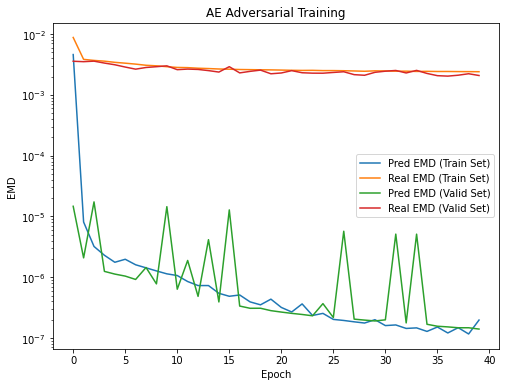

In [45]:
plt.figure(figsize=(8,6))
plt.plot(ae_pemd_train_loss, label='Pred EMD (Train Set)')
plt.plot(ae_temd_train_loss, label='Real EMD (Train Set)')
plt.plot(ae_pemd_valid_loss, label='Pred EMD (Valid Set)')
plt.plot(ae_temd_valid_loss, label='Real EMD (Valid Set)')

plt.title('AE Adversarial Training')
plt.yscale('log')
plt.ylabel('EMD')
plt.xlabel('Epoch')
plt.legend()

plt.show()

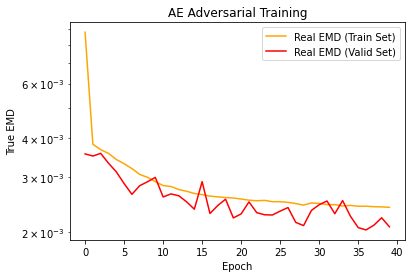

In [42]:
plt.plot(ae_temd_train_loss, label='Real EMD (Train Set)', color='orange')
plt.plot(ae_temd_valid_loss, label='Real EMD (Valid Set)', color='r')
plt.title('AE Adversarial Training')
plt.yscale('log')
plt.ylabel('True EMD')
plt.xlabel('Epoch')
plt.legend()

plt.show()

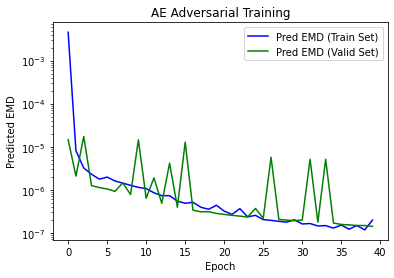

In [43]:
plt.plot(ae_pemd_train_loss, label='Pred EMD (Train Set)', color='b')
plt.plot(ae_pemd_valid_loss, label='Pred EMD (Valid Set)', color='g')

plt.title('AE Adversarial Training')
plt.yscale('log')
plt.ylabel('Predicted EMD')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [ ]:
# algo 2:
# generate all reco-jet pairs over the training data
# optimize the emd nn on those pairs
# use optimized emd nn to repredict loss per pair of reco jets. sum all losses
# update using batch gradient descent
# reset emd nn ?